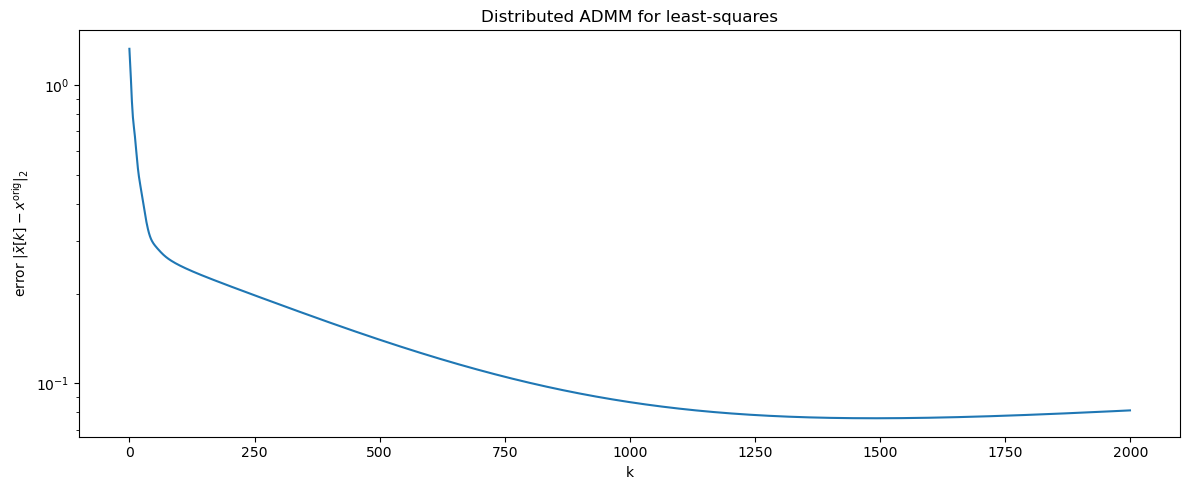

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ================== 参数设置 ==================
m = 20          # 测量次数 (= 行数)
n = 20          # 向量维度 (= 列数)
rho = 1.0       # ADMM 参数 ρ
sigma = 0.01    # 噪声标准差（协方差为 0.01^2 I）

np.random.seed(1)

# ================== 生成原始稀疏向量 x_orig ==================
x_orig = np.zeros(n)
idx = np.random.choice(n, size=2, replace=False)  # 有两个非零元素
x_orig[idx] = 1.0                                 # 二值向量：非零元素取 1

# ================== 生成观测矩阵和观测向量 ==================
A = np.random.randint(2, size=(m, n))             # 20×20 的二值矩阵
w = sigma * np.random.randn(m)                    # 高斯噪声 w ~ N(0, 0.01^2 I)
b = A @ x_orig + w                                # b = A x_orig + w

# ================== 预计算 Q_i = (a_i a_i^T + ρ I)^(-1) ==================
Q = []
for i in range(m):
    a_i = A[i, :].reshape(-1, 1)                  # (n,1)
    Q_i = np.linalg.inv(a_i @ a_i.T + rho * np.eye(n))
    Q.append(Q_i)

# ================== 分布式 ADMM 迭代 ==================
# 局部变量 x_i 和缩放对偶变量 u_i，维度都是 (m, n)
x_i = np.zeros((m, n))
u_i = np.zeros((m, n))
x_bar = x_i.mean(axis=0)                          # 共识变量 \bar{x}[0]

max_itr = 2000
error = np.zeros(max_itr)

for k in range(max_itr):
    # ---- x_i 更新：x_i^{k+1} = Q_i ( b_i a_i + ρ( \bar{x}^k - u_i^k ) ) ----
    for i in range(m):
        a_i = A[i, :].reshape(-1, 1)
        rhs = b[i] * a_i + rho * (x_bar - u_i[i]).reshape(-1, 1)
        x_i[i] = (Q[i] @ rhs).ravel()

    # ---- 共识变量更新：\bar{x}^{k+1} = (1/m) Σ_i x_i^{k+1} ----
    x_bar = x_i.mean(axis=0)

    # ---- 对偶变量更新：u_i^{k+1} = u_i^k + x_i^{k+1} - \bar{x}^{k+1} ----
    for i in range(m):
        u_i[i] = u_i[i] + x_i[i] - x_bar

    # ---- 记录误差 ||\bar{x}[k] - x_orig||_2 ----
    error[k] = np.linalg.norm(x_bar - x_orig)

# ================== 画误差曲线 ==================
plt.figure(figsize=(12, 5))
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.semilogy(error)
plt.xlabel("k")
plt.ylabel(r"error $\|\bar{x}[k]-x^{\rm orig}\|_2$")
plt.title("Distributed ADMM for least-squares")
plt.tight_layout()
plt.show()

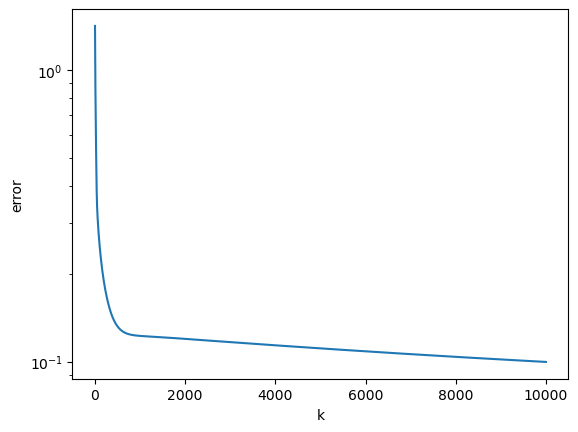

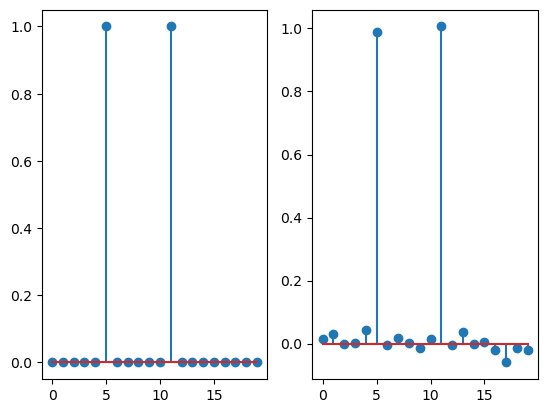

In [2]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

# Parameter settings
m = 20  # Number of tests
n = 20  # Number of people
k = 2   # Number of positives

# Original vector
np.random.seed(1)
x_orig = np.zeros(n)
S = np.random.randint(n, size=k)
x_orig[S] = 1

# Testing matrix
A = np.random.randint(2, size=(m, n))

# Result vector with noise
b = A @ x_orig + 0.01 * np.random.rand(m)

# Distributed ADMM
# Parameters
rho = 1
N_agents = m
Q = np.zeros((n, n, N_agents))
for i in range(N_agents):
    fi = A[i, :].reshape(1, -1)
    Q[:, :, i] = LA.inv(fi.T @ fi + rho * np.eye(n))

max_itr = 10000  # number of iterations
x = np.zeros((n, N_agents))
u = np.zeros((n, N_agents))
error = np.zeros(max_itr)
x_bar = np.sum(x, axis=1) / N_agents

for k in range(max_itr):
    error[k] = LA.norm(np.sum(x, axis=1)/N_agents - x_orig)
    for i in range(N_agents):
        qi = b[i] * A[i, :]
        x_next = Q[:, :, i] @ (qi + rho * (x_bar - u[:, i]))
        x[:, i] = x_next
    x_bar = np.sum(x, axis=1) / N_agents
    for i in range(N_agents):
        u_next = u[:, i] + x[:, i] - x_bar
        u[:, i] = u_next

# x_est = np.sum(x, axis=1)/N_agents

# Error analysis
plt.figure()
plt.semilogy(error)
plt.xlabel("k")
plt.ylabel("error")

# Reconstructed vector
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.stem(x_orig)
ax2 = fig.add_subplot(1, 2, 2)
ax2.stem(np.sum(x, axis=1)/N_agents)
plt.show()